In [1]:
import os
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split



# Manually define stopwords (common English stopwords)
STOPWORDS = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it',
    "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
    'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
    'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
    'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just',
    'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn',
    "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
    "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
])

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
# Load dataset
df = pd.read_csv(os.path.join('DataSet', 'train.csv','train.csv'))

In [4]:
# Text Preprocessing Function
def preprocess_text(text):
    # Remove special characters and lowercasing the text
    text = re.sub(r'[^A-Za-z\s]', '', text.lower())
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOPWORDS]
    return ' '.join(tokens)

# Apply preprocessing to the comment column
df['cleaned_comment'] = df['comment_text'].apply(preprocess_text)

# Split features and labels
X = df['cleaned_comment'].values
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Tokenization and padding sequences
MAX_FEATURES = 50000  # Maximum number of words in the vocabulary
MAX_LEN = 200  # Maximum sequence length

tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=MAX_LEN)

# Split dataset into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(8)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(8)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(8)

# Load GloVe Embeddings
embedding_dim = 100  # You can change this to match the GloVe embedding dimensions
embedding_index = {}

# Load the GloVe file (make sure you download and place the file in your working directory)
glove_file = 'glove.twitter.27B.100d.txt'  # Path to GloVe file (adjust as necessary)

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Found {len(embedding_index)} word vectors.")

# Create Embedding Matrix
vocab_size = min(MAX_FEATURES, len(tokenizer.word_index)) + 1  # +1 for padding
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector



Found 1193514 word vectors.


In [5]:
# Build Model
model = tf.keras.Sequential()

# Embedding Layer with GloVe
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_LEN,
                    weights=[embedding_matrix], trainable=False))  # Use pre-trained GloVe embeddings

# Bidirectional LSTM Layers
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))

# Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))  # Output 6 nodes for multi-label classification

# Compile the Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the Model
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=3, 
                    callbacks=[early_stopping])

c:\Users\rages\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 700s 217ms/step - accuracy: 0.8312 - loss: 0.0907 - val_accuracy: 0.9945 - val_loss: 0.0504
Epoch 2/3
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 520s 163ms/step - accuracy: 0.9922 - loss: 0.0531 - val_accuracy: 0.9945 - val_loss: 0.0467
Epoch 3/3
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 390s 122ms/step - accuracy: 0.9924 - loss: 0.0491 - val_accuracy: 0.9945 - val_loss: 0.0450


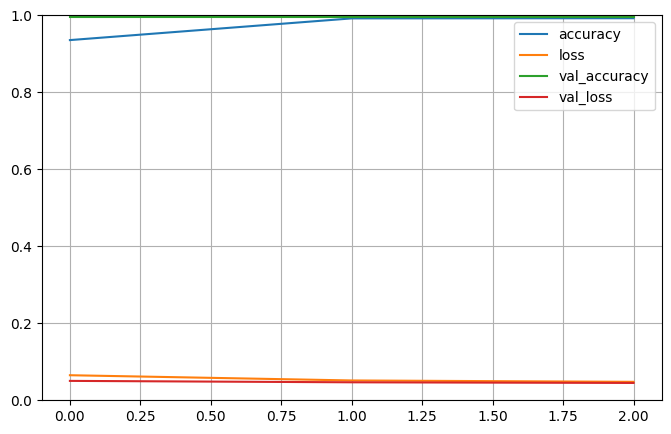

998/998 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.9943 - loss: 0.0462
Test Accuracy: 0.9936704635620117


In [6]:
# Plot training and validation history
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Evaluate the Model on Test Set
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc}')

In [7]:
model.save('toxicity.h5')

In [8]:
model = tf.keras.models.load_model('toxicity.h5')

In [9]:
# Function to Score a Comment and Return Label Predictions (True/False)
def score_comment(comment):
    # Preprocess the comment
    cleaned_comment = preprocess_text(comment)
    
    # Tokenize and pad the comment
    vectorized_comment = tokenizer.texts_to_sequences([cleaned_comment])
    vectorized_comment = pad_sequences(vectorized_comment, maxlen=MAX_LEN)
    
    # Get prediction for the comment
    result = model.predict(vectorized_comment)[0]
    
    # Map the results to the corresponding labels with True/False
    label_dict = {}
    for idx, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
        label_dict[label] = result[idx] > 0.4  # True if score is above 0.5, else False

    label_str = ''
    for key in label_dict:
        label_str+=f'{key}:{label_dict[key]}\n'
    
    # Return the dictionary of labels and their values
    return label_str


In [10]:
# Gradio Interface for Comment Scoring and Toxicity Removal
import gradio as gr

iface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder="Enter a comment to check if it's toxic..."),
    outputs="text",
    title="Toxic Comment Classifier",
    description="Enter a comment, and the system will tell you if it's toxic or non-toxic."
)

# Launch Gradio Interface
iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://049080f1c99840c758.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
